# Analyzing RITA Flights Data
## by Adnan Sawas

## Investigation Overview

The goal of this presentation is to have a quick insights on flights data sample focusing on flights delays and thier causes. 

## Dataset Overview

The dataset is a collection of flights data from 2005 till 2008. Data is originally coming from the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS). BTS began collecting details on the causes of flight delays in June 2003. Summary statistics and raw data are made available to the public at the time the Air Travel Consumer Report is released.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
allFilesPath = [f"data/{year}.csv" for year in range(2005, 2009)]
df = pd.concat([pd.read_csv(filePath, encoding="ISO-8859-1", low_memory=False) for filePath in allFilesPath])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28745461 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 6.4+ GB


In [4]:
df.drop(columns=["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime", "FlightNum", "TailNum", "ActualElapsedTime", "CRSElapsedTime", "TaxiIn", "TaxiOut", "Diverted"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28745461 entries, 0 to 7009727
Data columns (total 18 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
UniqueCarrier        object
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
Cancelled            int64
CancellationCode     object
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(8), int64(6), object(4)
memory usage: 4.1+ GB


2.3 GB of data has been cleaned out.

In [5]:
# Convert Year column to string then to categorical
df.Year = df.Year.astype(str)

# Making the years ordered
years_order = ['2005', '2006', '2007', '2008']
ordered_cat = pd.api.types.CategoricalDtype(ordered = True, categories = years_order)
df['Year'] = df['Year'].astype(ordered_cat)

In [6]:
# Add the totalDelay column
df['totalDelay'] = df.DepDelay + df.ArrDelay

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

### Dataset Structure

|Column Name | Description |
| -----: | ----------: |
|Year    |1987-2008    |
|Month   |1-12
|DayofMonth|	1-31
|DayOfWeek |	1 (Monday) - 7 (Sunday)
|DepTime	  | actual departure time (local, hhmm)
|CRSDepTime |	scheduled departure time (local, hhmm)
|ArrTime	actual | arrival time (local, hhmm)
|CRSArrTime |	scheduled arrival time (local, hhmm)
|UniqueCarrier |	unique carrier code
|AirTime	 | in minutes
|ArrDelay |	arrival delay, in minutes
|DepDelay |	departure delay, in minutes
|Origin	 | origin IATA airport code
|Dest	 | destination IATA airport code
|Distance |	in miles
|Cancelled |	was the flight cancelled?
|CancellationCode |	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
|CarrierDelay |	in minutes
|WeatherDelay |	in minutes
|NASDelay |	in minutes
|SecurityDelay |	in minutes
|LateAircraftDelay |	in minutes

## The main features of interest are:
- **Year:** How different variables changed through time
- **ArrDelay & DeptDelay:** What are delay factors and main reasons for delay. Actually, I would add these two variables into one column `totalDelay` to avoid dealing with multiple columns.
- **CancelationCode:** What are main reasons for cancelling a flight?
- **AirTime:** What affects the Air time?

## Cancelled Flights Percentages Per Year

Although percentage of cancelled flights is only 1.93%, it is good to know how cancelled flights are distributed over the yers.

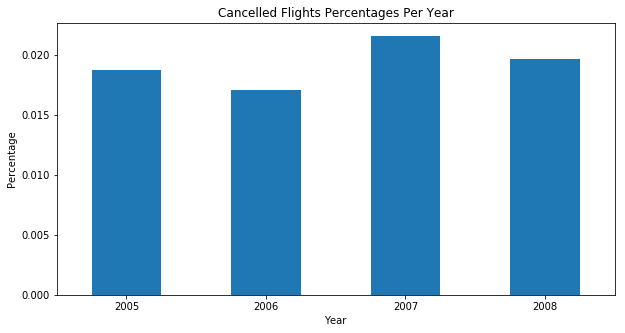

In [9]:
canceledFlights = df[df.Cancelled == True].Year.value_counts().sort_index()
dfYearsCount = df.Year.value_counts().sort_index()
canceledFlightsPercentage = canceledFlights / dfYearsCount
canceledFlightsPercentage.plot(kind="bar", figsize=(10,5))
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.title("Cancelled Flights Percentages Per Year")
plt.xticks(rotation=0);

Percentage of cancelled flights is almost stable over the yers. Year 2006 was the best perfomance year in terms of percentage of cancelled flights while year 2007 was the worst.

## Carriers Operating Short or Long Flights

Let's see how short and long flights are distributed through carriers.

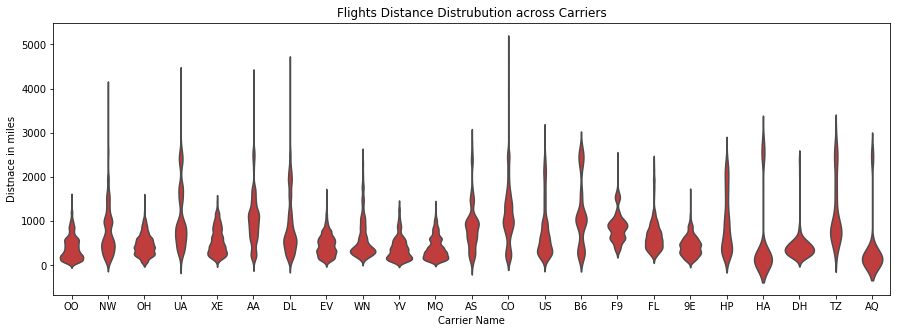

In [10]:
carrierDelay = df.sample(100000, replace=False)
plt.figure(figsize = [15, 5])
base_color = sb.color_palette()[3]
sb.violinplot(data=carrierDelay, x="UniqueCarrier", y="Distance", inner=None, color=base_color);
plt.xlabel("Carrier Name")
plt.ylabel("Distnace in miles")
plt.title("Flights Distance Distrubution across Carriers");

- From the graph above, we see that most carriers tend to operate flights that are less than 1000 miles. 
- Carriers focusing only on short flights are: MQ, YV, OH, EV, OO, 9E, DH
- Carriers UA, CO, B6. HP and TZ tend to have more diversed flights (short and long flights)
- Carriers UA, DL, AA, NW and CO are the only carriers who operate very long flights (> 3500 miles)

## Departure Delay and Air Time Relation Across Carriers

Let's see how departure delay affects air time across cariers. 

I have picked the most frequesnt fligth for this which is (SAN -> LAX) flight.

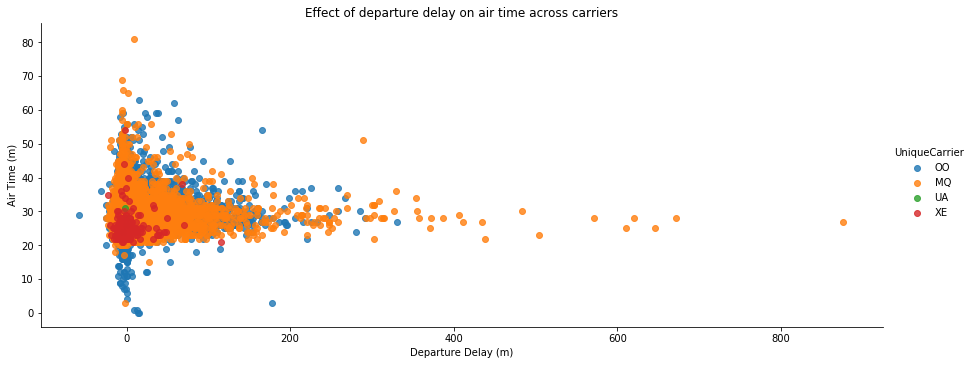

In [18]:
most_frequent_flight_df = df.loc[(df.Origin == "SAN") & (df.Dest == "LAX") & (df.Cancelled == 0)]
# most_frequent_flight_df_sample = most_frequent_flight_df.sample(3000, replace=False)
g = sb.FacetGrid(data=most_frequent_flight_df, hue="UniqueCarrier", height=5, aspect=2.5)
g = g.map(sb.regplot, "DepDelay", "AirTime", fit_reg=False)
g.add_legend()
plt.xlabel('Departure Delay (m)')
plt.ylabel('Air Time (m)')
plt.title('Effect of departure delay on air time across carriers');

Flights with low departure delay tend to have more propbability of higher AirTime (although this is actually very rare). About 0.2% of flight have departure delay > 200 minutes. These flights have almost consistent air time of approximately 28 minutes. I think because the flight is very short, the effect of departure time on air time is not that obvious. 

> Another observation is that this flight is mostly operated by OO and MQ carriers. 

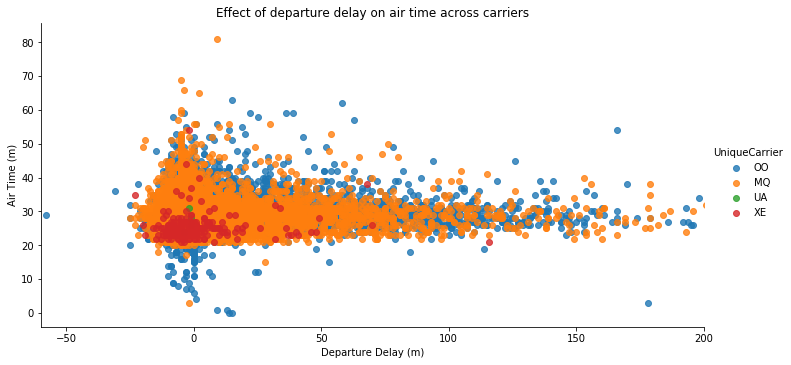

In [17]:
g = sb.FacetGrid(data=most_frequent_flight_df, hue="UniqueCarrier", height=5, aspect=2)
g = g.map(sb.regplot, "DepDelay", "AirTime", fit_reg=False, )
plt.xlim([-60, 200])
g.add_legend()
plt.xlabel('Departure Delay (m)')
plt.ylabel('Air Time (m)')
plt.title('Effect of departure delay on air time across carriers');

Zooming to flights with less than 200 minutes departure delay, we see that air time becomes more stable as the flght gets delayed. However, the graph is a little bit decieving since 75% of flights actually do have a departure delay that is less than zero! (which is pretty interesting!)

In [19]:
most_frequent_flight_df[["DepDelay", "AirTime"]].describe()

,DepDelay,AirTime
count,52863.000000,52860.000000
mean,1.417362,28.880401
std,21.155780,3.318275
min,-58.000000,0.000000
25%,-5.000000,27.000000
50%,-4.000000,29.000000
75%,0.000000,30.000000
max,876.000000,81.000000


> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!